In [69]:
import argparse
import os
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from tqdm import tqdm
from matplotlib import pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [70]:
BATCH_SIZE = 16
EPOCHS = 50
Z_DIM = 2
LEARNING_RATE = 0.001

In [3]:
train_data = datasets.FashionMNIST('./data', train=True, download=True,
                            transform=transforms.ToTensor())
test_data = datasets.FashionMNIST('./data', train=False,
                           transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [4]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 500)
        self.fc21 = nn.Linear(500, Z_DIM)  # fc21 for mean of Z
        self.fc22 = nn.Linear(500, Z_DIM)  # fc22 for log variance of Z

        self.fc3 = nn.Linear(Z_DIM, 500)
        self.fc4 = nn.Linear(500, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        mu = self.fc21(h1)
        # I guess the reason for using logvar instead of std or var is that
        # the output of fc22 can be negative value (std and var should be positive)
        logvar = self.fc22(h1)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.rand_like(std)
        return mu + eps*std

    def decode(self, z):
        x = F.relu(self.fc3(z))
        x = torch.sigmoid(self.fc4(x))
        return x

    def forward(self, x):
        # x: [batch size, 1, 28, 28] -> x: [batch size, 784]
        x = x.view(-1, 784)

        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)

        x = self.decode(z)
        return x, mu, logvar

In [5]:
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [6]:
def loss_function(output, x, mu, logvar):
    BCE = F.binary_cross_entropy(output, x.view(-1, 784), reduction='sum')
    KLD = 0.5 * torch.sum(mu.pow(2) + logvar.exp() - logvar - 1)

    return BCE + KLD

In [9]:
for epoch in tqdm(range(EPOCHS)):
    train_loss = 0

    for i, (data, _) in enumerate(train_loader):
        optimizer.zero_grad()

        data = data.to(device)

        output, mu, logvar = model(data)

        loss = loss_function(output, data, mu, logvar)
        loss.backward()
        optimizer.step()

        cur_loss = loss.item()
        train_loss += cur_loss

        # if i % LOG_INTERVAL == 0:
        #     print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        #         epoch, i * len(data), len(train_loader.dataset),
        #         100.*i / len(train_loader),
        #         cur_loss/len(data)))

    print(f'====> Epoch: {epoch + 1} Average loss: {train_loss/len(train_loader.dataset)}')

  2%|▏         | 1/50 [00:16<13:31, 16.56s/it]

====> Epoch: 1 Average loss: 267.81200001627604


  4%|▍         | 2/50 [00:32<12:55, 16.15s/it]

====> Epoch: 2 Average loss: 264.7150905965169


  6%|▌         | 3/50 [00:48<12:30, 15.96s/it]

====> Epoch: 3 Average loss: 263.19269557291665


  8%|▊         | 4/50 [01:03<12:04, 15.74s/it]

====> Epoch: 4 Average loss: 262.36673346354166


 10%|█         | 5/50 [01:19<11:52, 15.84s/it]

====> Epoch: 5 Average loss: 261.67574065755207


 12%|█▏        | 6/50 [01:35<11:31, 15.71s/it]

====> Epoch: 6 Average loss: 261.258170711263


 14%|█▍        | 7/50 [01:50<11:09, 15.57s/it]

====> Epoch: 7 Average loss: 260.86158650716146


 16%|█▌        | 8/50 [02:05<10:55, 15.60s/it]

====> Epoch: 8 Average loss: 260.5826001261393


 18%|█▊        | 9/50 [02:21<10:34, 15.48s/it]

====> Epoch: 9 Average loss: 260.28899979248047


 20%|██        | 10/50 [02:37<10:24, 15.62s/it]

====> Epoch: 10 Average loss: 260.0169481323242


 22%|██▏       | 11/50 [02:53<10:17, 15.84s/it]

====> Epoch: 11 Average loss: 259.8010811523437


 24%|██▍       | 12/50 [03:09<10:06, 15.97s/it]

====> Epoch: 12 Average loss: 259.5766039957682


 26%|██▌       | 13/50 [03:25<09:49, 15.94s/it]

====> Epoch: 13 Average loss: 259.39091462809245


 28%|██▊       | 14/50 [03:42<09:44, 16.23s/it]

====> Epoch: 14 Average loss: 259.2269413736979


 30%|███       | 15/50 [03:59<09:39, 16.56s/it]

====> Epoch: 15 Average loss: 259.13591673990885


 32%|███▏      | 16/50 [04:16<09:20, 16.50s/it]

====> Epoch: 16 Average loss: 259.02289384765623


 34%|███▍      | 17/50 [04:32<08:58, 16.32s/it]

====> Epoch: 17 Average loss: 258.8294538248698


 36%|███▌      | 18/50 [04:48<08:44, 16.38s/it]

====> Epoch: 18 Average loss: 258.7522980143229


 38%|███▊      | 19/50 [05:03<08:18, 16.08s/it]

====> Epoch: 19 Average loss: 258.6086166137695


 40%|████      | 20/50 [05:20<08:03, 16.13s/it]

====> Epoch: 20 Average loss: 258.5112663330078


 40%|████      | 20/50 [05:27<08:11, 16.40s/it]


KeyboardInterrupt: ignored

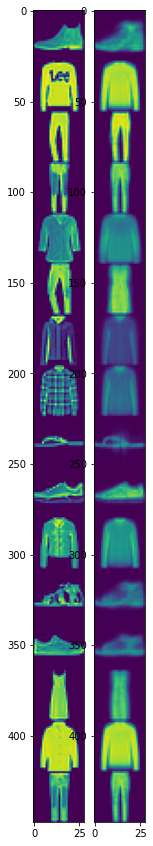

In [60]:
# Compress and reconstruct images

data, _ = next(iter(test_loader))
data = data.to(device)

recon_data, mu, logvar = model(data)

comparison = torch.cat([data[:8], recon_data.view(BATCH_SIZE, 1, 28, 28)[:8]]).cpu()

f, ax = plt.subplots(1, 2, figsize=(2, 18))
ax = ax.flatten()

ax[0].imshow(data.view(BATCH_SIZE * 28, 28).cpu().detach().numpy())
ax[1].imshow(recon_data.view(BATCH_SIZE * 28, 28).cpu().detach().numpy())
plt.show()

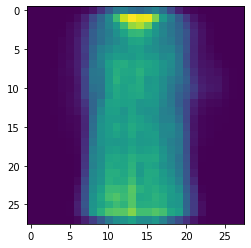

In [68]:
# Create a new image

sample = torch.randn(1, Z_DIM).to(device)
sample = model.decode(sample).cpu().view(28, 28).detach().numpy()

plt.imshow(sample)
plt.show()